In [1]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from keras_video import VideoFrameGenerator
import glob

In [2]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [15]:
# use sub directories names as classes
classes = [i.split(os.path.sep)[1] for i in glob.glob('project_data/*')]
classes.sort()
# some global params
SIZE = (64, 64)
CHANNELS = 3
NBFRAME = 50
BS = 2
# pattern to get videos and classes
glob_pattern='project_data/{classname}/*.avi'
# for data augmentation
data_aug = ImageDataGenerator(
    zoom_range=1.5,
#     horizontal_flip=True,
#     rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split=.2, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class Backstroke, validation count: 8, train count: 32
class Breaststroke, validation count: 9, train count: 36
class Freestyle, validation count: 8, train count: 32
Total data: 3 classes for 100 files for train


In [16]:
valid = train.get_validation_generator()

Total data: 3 classes for 25 files for validation


In [5]:
train

In [6]:

x_train, y_train = next(train)
x_test, y_test = next(valid)

In [8]:
x_train.shape

(1, 10, 64, 64, 3)

In [2]:
data_dir = "project_data"
img_height , img_width = 100, 64
seq_len = 60
 
classes = ["Backstroke", "Breaststroke", "Freestyle"]
 
#  Creating frames from videos
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list
 
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y
 
X, Y = create_data(data_dir)

Backstroke
Breaststroke
Freestyle


In [3]:
X.shape

(125, 60, 64, 100, 3)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)
filepath = 'best_model_convlstm_fix.h5'
model = Sequential()
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), padding='same',return_sequences = True, data_format = "channels_last", 
                     input_shape = (seq_len, img_width, img_height, 3)))
# model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), padding='same',return_sequences = True, data_format = "channels_last", 
#                      input_shape = (NBFRAME,64,64, 3)))
model.add(Dropout(0.5))
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", ))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax"))
 
model.summary()
 
opt = optimizers.Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)
stop = EarlyStopping(monitor='val_loss', patience =5,
                      verbose=0, mode='auto', baseline=None, 
                      restore_best_weights=False)
callbacks = [checkpoint,stop]
 
history = model.fit(x = X_train, y = y_train, epochs=400, batch_size = 1 , shuffle=True, validation_data=(X_test,y_test), callbacks=callbacks)
# history = model.fit_generator(
#     train,
#     validation_data=valid,
#     verbose=1,
#     epochs=400,
#     callbacks=callbacks
# )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 60, 64, 100, 64)   154624    
_________________________________________________________________
dropout (Dropout)            (None, 60, 64, 100, 64)   0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 62, 98, 32)        110720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 98, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 194432)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               24887424  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

Epoch 23/400
100/100 [==============================] - ETA: 0s - loss: 6.0047e-04 - accuracy: 1.0000
Epoch 00023: val_loss improved from 0.00015 to 0.00012, saving model to best_model_convlstm_fix.h5
100/100 [==============================] - 39s 394ms/step - loss: 6.0047e-04 - accuracy: 1.0000 - val_loss: 1.2071e-04 - val_accuracy: 1.0000
Epoch 24/400
100/100 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000
Epoch 00024: val_loss did not improve from 0.00012
100/100 [==============================] - 39s 389ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 25/400
100/100 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9600
Epoch 00025: val_loss did not improve from 0.00012
100/100 [==============================] - 39s 389ms/step - loss: 0.0955 - accuracy: 0.9600 - val_loss: 0.0173 - val_accuracy: 1.0000
Epoch 26/400
100/100 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 

In [6]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
# y_test = np.argmax(y_test, axis = 1)
 
print(classification_report(y_test, y_pred))

NameError: name 'X_test' is not defined

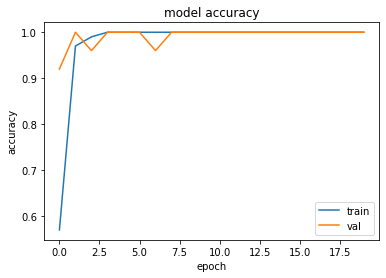

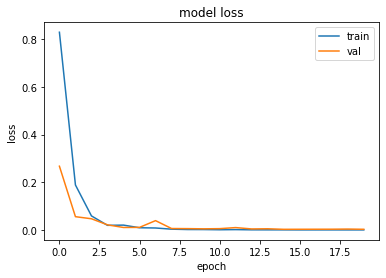

In [6]:
# use LSTM model to predict

# import seaborn as sns
import matplotlib.pyplot as plt
# y_pred_ohe = model.predict(X_test)
# y_pred_labels = np.argmax(y_pred_ohe, axis=1)
# y_true_labels = y_test
# confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
# print(y_true_labels)

# plt.figure(figsize=(8, 6))
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)
# sns.heatmap(confusion_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show();

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
model.save("model_har.h5")